# I.Import et etudes fichiers

In [1]:
# installations et imports des autres packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import fonctions as fc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
# file path
data_file_path = "data.csv"
data = pd.read_csv(data_file_path)

In [3]:
data.head()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
0,-1.640748,-1.193612,0.000000,-0.649493,-0.402473,-1.108822
1,0.491588,-0.259106,0.189995,0.336682,0.894770,0.044080
2,-0.039494,0.462597,0.000000,0.491070,-0.232230,-0.135996
3,-0.795007,-0.807085,0.000000,-1.791128,-0.134871,-0.176583
4,0.117503,-0.572858,3.909364,0.386350,0.396982,0.903506


In [4]:
data_num = data.select_dtypes(include=[np.number])

## POIDS des colonnes

In [5]:
# # Suppose 'column1' and 'column2' are the columns you want to give more weight
# weight = 2  # Change this to the weight you want
# df['column1'] = df['column1'] * weight
# df['column2'] = df['column2'] * weight

# # Then perform the clustering

# V.PCA

In [6]:
# from sklearn.decomposition import PCA

# # Définir une plage de nombres de composantes à tester
# plage_de_composantes = range(1, min(data_num.shape[0], data_num.shape[1]) + 1)

# # Listes pour stocker la variance expliquée et la variance expliquée cumulative
# variance_expliquee = []

# # Itérer à travers différents nombres de composantes
# for n_composantes in plage_de_composantes:
#     pca_pivot = PCA(n_components=n_composantes)
#     composantes_principales_pivot = pca_pivot.fit_transform(data_num)

#     # Calculer la variance expliquée et la variance expliquée cumulative
#     variance_expliquee.append(np.sum(pca_pivot.explained_variance_ratio_))

# # Tracer la variance expliquée et la variance expliquée cumulative
# plt.bar(x_list, scree)
# plt.plot(x_list, scree_cum,c="red",marker='o')
# plt.xlabel("rang de l'axe d'inertie")
# plt.ylabel("pourcentage d'inertie")
# plt.title("Eboulis des valeurs propres")
# plt.show(block=False)

## ACP 2 components

In [7]:
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(data_num)

PCA(n_components=2)

In [8]:
pca.explained_variance_ratio_

array([0.74324761, 0.14240301])

In [9]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([74.32, 14.24])

Notre colonne F1 explique à elle seul 74% de l'information contneu dans nos données d'origine.

In [10]:
scree_cum = scree.cumsum().round()
scree_cum

array([74., 89.])

Nos deux colonnes F1 et F2 explique 89% de l'information contenu dans nos données d'origine.

In [11]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2]

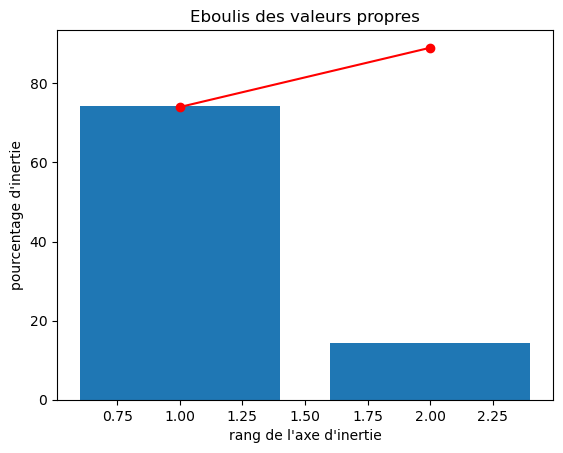

In [12]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [13]:
pcs = pca.components_
pcs

array([[-0.0653643 , -0.06794791, -0.98616963, -0.0744329 , -0.07274122,
        -0.0880256 ],
       [-0.52963072, -0.57800337,  0.15331988, -0.47056079, -0.19108814,
        -0.32241943]])

In [14]:
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5
0,-0.065364,-0.067948,-0.98617,-0.074433,-0.072741,-0.088026
1,-0.529631,-0.578003,0.15332,-0.470561,-0.191088,-0.322419


In [15]:
features = data_num.columns
features

Index(['Disponibilité de protéines en quantité (kg/personne)',
       'Disponibilité intérieure/ Population', 'Exportations / Population',
       'Importations / Population', 'Production / Population',
       'PIB US $ par habitant'],
      dtype='object')

In [16]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
F1,-0.07,-0.07,-0.99,-0.07,-0.07,-0.09
F2,-0.53,-0.58,0.15,-0.47,-0.19,-0.32


In [17]:
x, y = 0,1

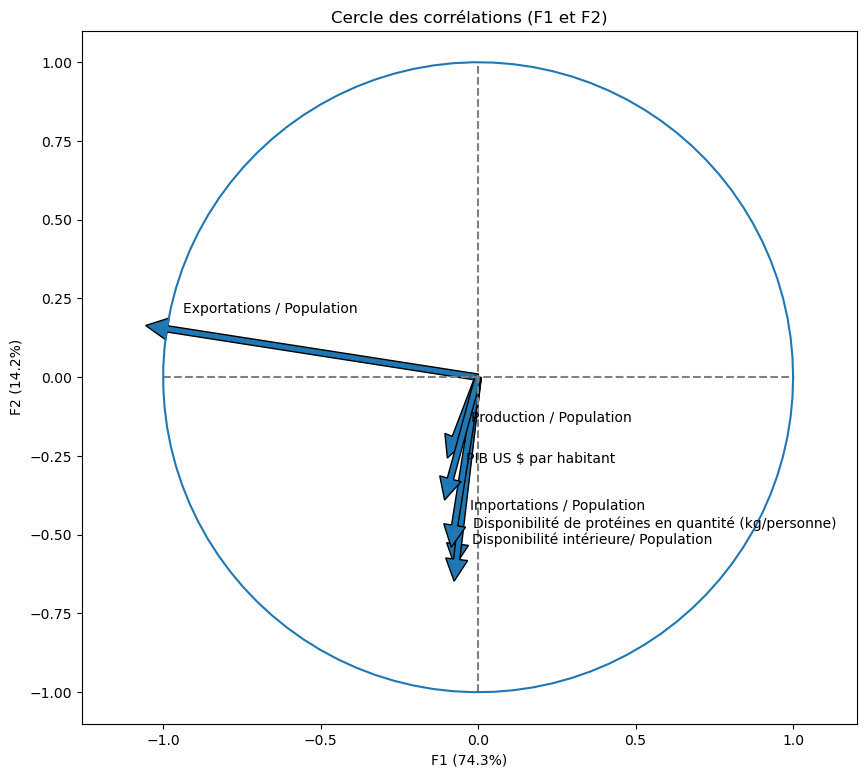

In [18]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07,
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

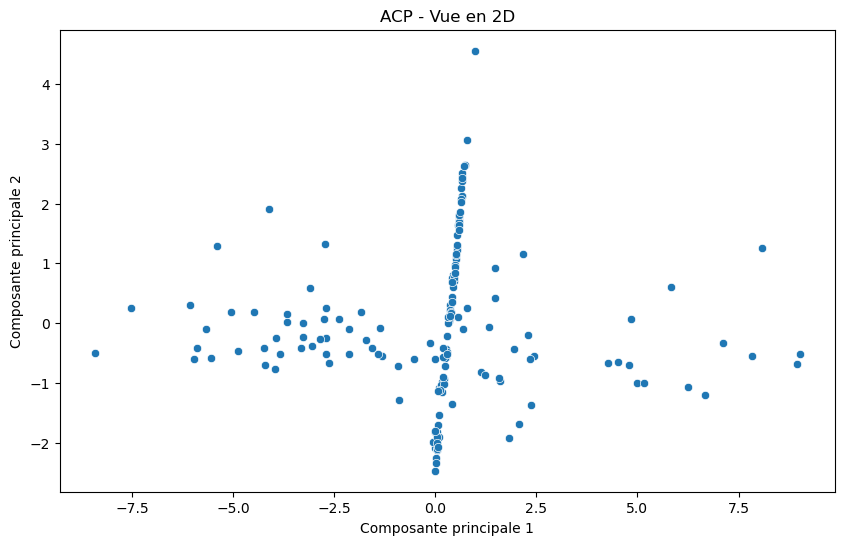

In [19]:
# Application de l'ACP
pca_pivot = PCA(n_components=2)  # Ajuster le nombre de composantes
principal_components_pivot = pca_pivot.fit_transform(data_num)

# Visualisation des résultats de l'ACP
plt.figure(figsize=(10, 6))
sns.scatterplot(x=principal_components_pivot[:, 0], y=principal_components_pivot[:, 1])
plt.title('ACP - Vue en 2D')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()

In [20]:
X_proj = pca.transform(data_num)
X_proj[:10]

array([[ 6.56480641e-01,  2.13118074e+00],
       [-3.01421088e-03, -5.92847815e-01],
       [ 2.56367201e-01, -5.57080465e-01],
       [ 5.58384323e-01,  1.64533771e+00],
       [-3.66831139e+00,  1.51535567e-01],
       [ 3.70577504e-01,  2.99727075e-01],
       [ 2.31985537e-02, -2.25061938e+00],
       [ 2.37471134e+00, -1.36547047e+00],
       [-2.70397157e+00,  2.62460104e-01],
       [ 2.76151924e-01, -4.34740306e-01]])

In [21]:
df = pd.DataFrame(X_proj, columns = ["F1", "F2"])
df_test = df.copy()
df.head()

,F1,F2
0,0.656481,2.131181
1,-0.003014,-0.592848
2,0.256367,-0.557080
3,0.558384,1.645338
4,-3.668311,0.151536


# IV.Dendogramme

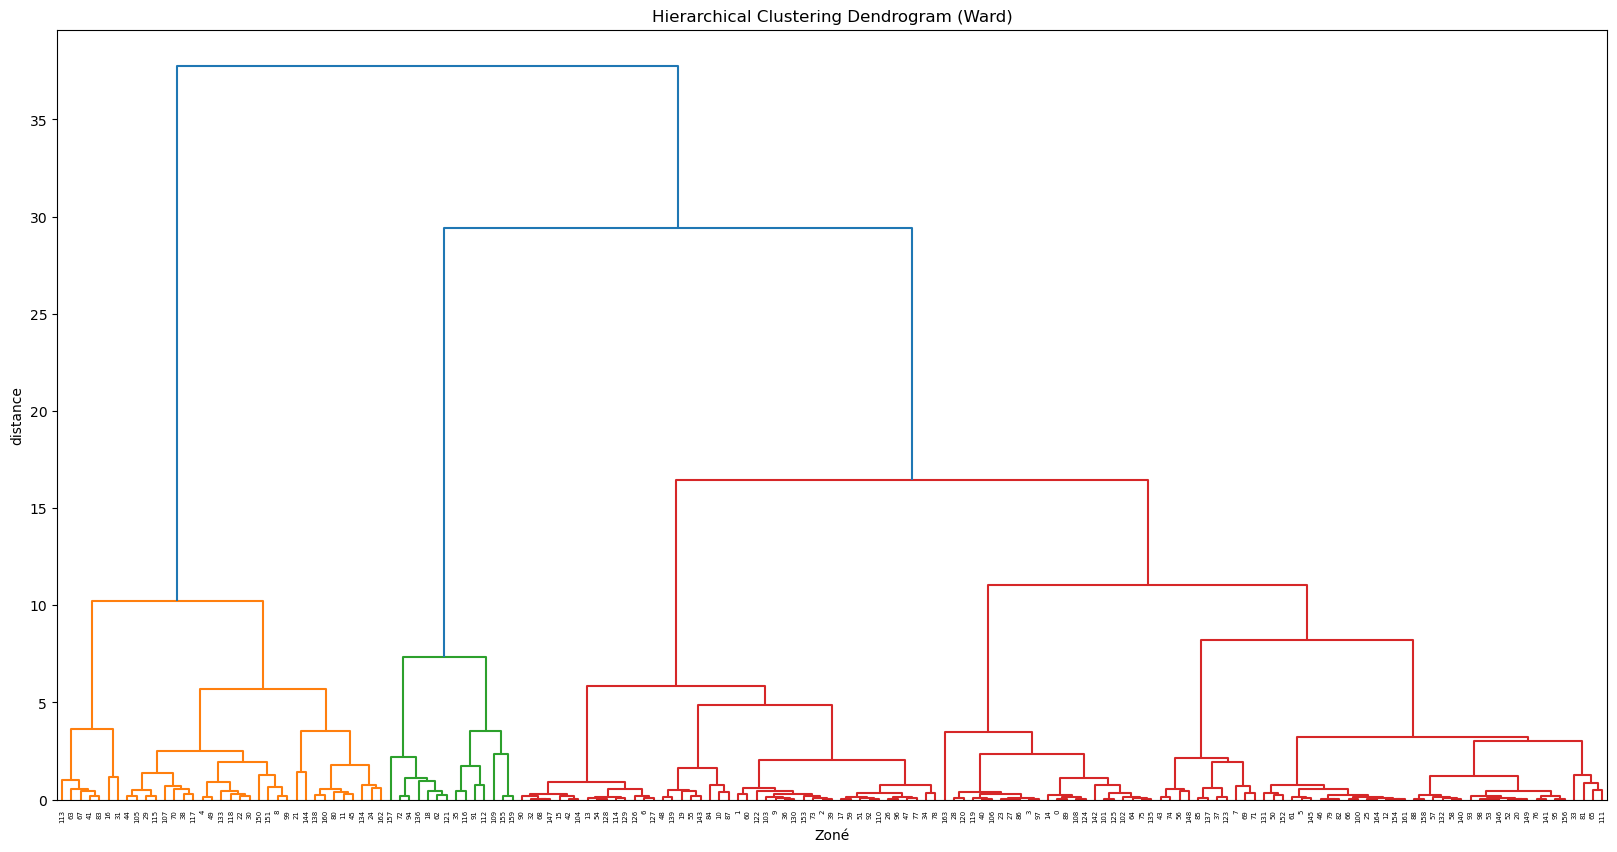

In [22]:
# Supposez que `X` est votre data et `zone` est votre colonne "Zoné"
Z = linkage(df_test, 'ward')

# # Convertir la colonne "Zoné" en liste de strings
# # Copiez la colonne "Zoné" dans une autre variable
# zone = data['Zone'].copy()
# labels = zone.astype(str).tolist()
'''labels=labels'''
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Zoné')
plt.ylabel('distance')
dendrogram(Z,  leaf_rotation=90)
plt.show()

In [23]:
# Coupage du dendrogramme en 2 clusters
clusters = fcluster(Z, 2, criterion='maxclust')
clusters

array([2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1,
       1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2,
       1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2], dtype=int32)

In [24]:
df['cluster_dd'] = clusters

In [25]:
# # Coupage du dendrogramme en 5 clusters
# clusters = fcluster(Z, 5, criterion='maxclust')

# Coupage du dendrogramme en 2 clusters
clusters = fcluster(Z, 2, criterion='maxclust')

# Création des dataframes pour chaque cluster
cluster_dataframes = []
for cluster_id in range(1, 3):
    cluster_indices = [i for i, cluster_label in enumerate(clusters) if cluster_label == cluster_id]
    cluster_dataframe = data.iloc[cluster_indices]
    cluster_dataframes.append(cluster_dataframe)

# Assignation des clusters à des variables
cluster_1_dd = cluster_dataframes[0]
cluster_2_dd = cluster_dataframes[1]

cluster_1_dd.head()

# # Creattion de clusters 
# cluster_1_dd = cluster_dataframes[0]
# cluster_2_dd = cluster_dataframes[1]
# # cluster_3_dd = cluster_dataframes[2]
# # cluster_4_dd = cluster_dataframes[3]
# # cluster_5_dd = cluster_dataframes[4]

cluster_1_dd.head()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
4,0.117503,-0.572858,3.909364,0.386350,0.396982,0.903506
8,0.464159,-0.186489,2.947036,-1.251309,1.803495,0.396276
11,0.077732,0.150712,4.144586,0.468755,0.327061,0.930709
16,-0.245121,-0.099378,7.702186,0.820426,1.409914,0.898316
21,0.560531,-0.653980,5.726072,-2.282808,2.675848,0.219507


# VI.Kmeans

In [26]:
# Import the os module
import os

# Set the environment variable 'OMP_NUM_THREADS' to '1'
os.environ['OMP_NUM_THREADS'] = '1'

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

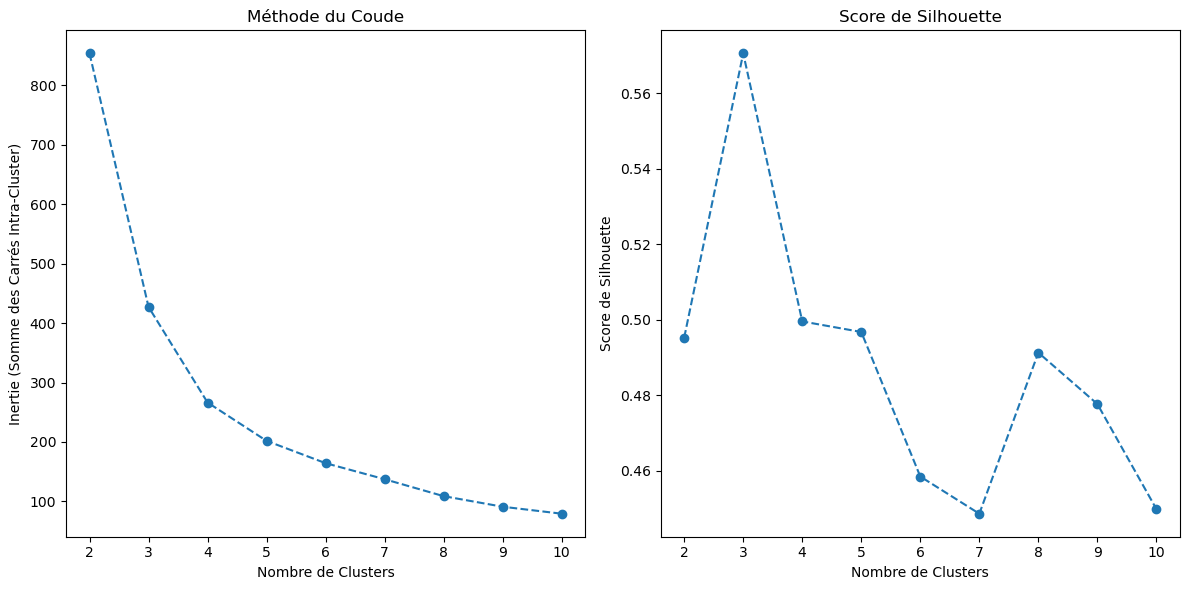

In [27]:
# Définir une plage de nombres de clusters à tester
plage_de_clusters = range(2, 11)  # Vous pouvez ajuster la plage selon vos besoins

# Listes pour stocker l'inertie et les scores de silhouette
valeurs_inertie = []
scores_silhouette = []

# Itérer à travers différents nombres de clusters et ajuster K-Means
for n_clusters in plage_de_clusters:
    kmeans_pivot = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters_pivot = kmeans_pivot.fit_predict(df_test)

    # Calculer l'inertie (somme des carrés intra-cluster)
    valeurs_inertie.append(kmeans_pivot.inertia_)

    # Calculer le score de silhouette
    scores_silhouette.append(silhouette_score(df_test, clusters_pivot))

# Tracer la méthode du coude pour déterminer le nombre optimal de clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(plage_de_clusters, valeurs_inertie, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie (Somme des Carrés Intra-Cluster)')
plt.title('Méthode du Coude')

# Tracer le Score de Silhouette pour déterminer le nombre optimal de clusters
plt.subplot(1, 2, 2)
plt.plot(plage_de_clusters, scores_silhouette, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette')

plt.tight_layout()
plt.show()

Méthode du Coude (Elbow Method) :

La Méthode du Coude consiste à trouver le point dans un graphique de l'inertie où la diminution de l'inertie ralentit, formant un coude.
Ce point représente généralement le nombre optimal de clusters dans une analyse de clustering.

Score de Silhouette (Silhouette Score) :

Le Score de Silhouette mesure à quel point les points d'un cluster sont similaires entre eux et différents des autres clusters.
Il varie de -1 à 1, où un score élevé indique une meilleure séparation des clusters.
Le nombre optimal de clusters est généralement celui qui donne le score de silhouette le plus élevé.

In [28]:
# Importer la classe KMeans du module sklearn.cluster
from sklearn.cluster import KMeans

# Créer une instance de la classe KMeans avec 2 clusters
kmeans = KMeans(n_clusters=2)

# Entraîner le modèle KMeans sur les données numériques
kmeans.fit(df_test)

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=2)

In [29]:
# Obtenir les labels attribués par KMeans à chaque échantillon
labels = kmeans.labels_

# Ajouter la colonne 'cluster' au dataframe 'data' avec les labels attribués par KMeans
df['cluster_kmeans'] = kmeans.labels_

# Afficher un échantillon aléatoire de 10 lignes du dataframe 'data' avec la colonne 'cluster'
df.sample(10)

,F1,F2,cluster_dd,cluster_kmeans
154,0.306362,0.112286,2,0
47,0.161401,-0.974805,2,0
13,-0.006205,-2.081131,2,0
66,0.330611,0.038924,2,0
139,-1.426927,-0.518208,2,1
146,0.463603,0.748437,2,0
149,0.416031,0.692816,2,0
93,0.432391,0.598096,2,0
161,0.310294,0.100164,2,0
110,0.068426,-1.126658,2,0


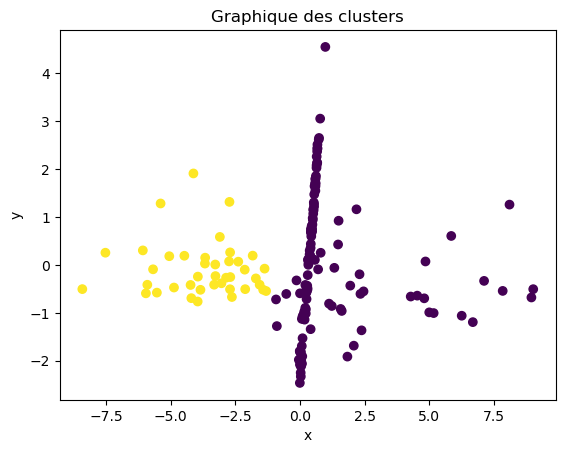

In [30]:
# Créer un graphique de dispersion avec le numéro du cluster
plt.scatter(df['F1'], df['F2'], c=df['cluster_kmeans'])

# Ajouter des étiquettes et un titre
plt.xlabel('x')
plt.ylabel('y')
plt.title('Graphique des clusters')

# Afficher le graphique
plt.show()

In [31]:
centroids = kmeans.cluster_centers_
centroids

array([[ 1.17988325,  0.02909421],
       [-3.68713515, -0.09091942]])

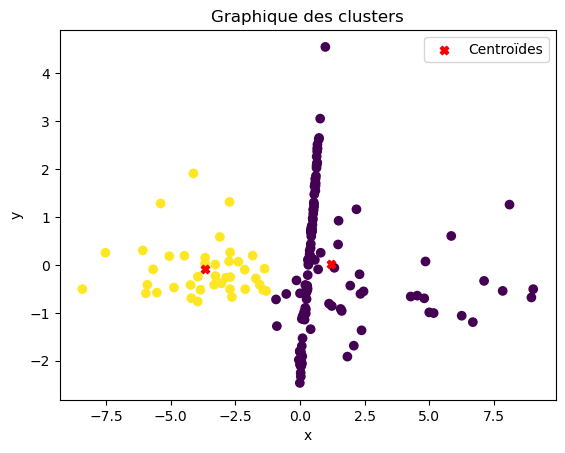

In [32]:
# Créer un graphique de dispersion
plt.scatter(df['F1'], df['F2'], c=df['cluster_kmeans'])

# Ajouter des étiquettes et un titre
plt.xlabel('x')
plt.ylabel('y')
plt.title('Graphique des clusters')

# Ajouter les centroïdes au graphique
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red', label='Centroïdes')

# Afficher le graphique
plt.legend()
plt.show()

In [33]:
df.loc[df['cluster_kmeans'] == 0, 'cluster_kmeans'] = 2
df.head()

,F1,F2,cluster_dd,cluster_kmeans
0,0.656481,2.131181,2,2
1,-0.003014,-0.592848,2,2
2,0.256367,-0.557080,2,2
3,0.558384,1.645338,2,2
4,-3.668311,0.151536,1,1


### Cluster 1

In [34]:
cluster_1_k = df[df["cluster_kmeans"]==1]
cluster_1_k.describe()

,F1,F2,cluster_dd,cluster_kmeans
count,40.000000,40.000000,40.000000,40.0
mean,-3.687135,-0.090919,1.125000,1.0
std,1.680971,0.568807,0.334932,0.0
min,-8.414747,-0.763492,1.000000,1.0
25%,-4.572383,-0.504890,1.000000,1.0
50%,-3.299764,-0.248367,1.000000,1.0
75%,-2.681493,0.159292,1.000000,1.0
max,-1.312916,1.910466,2.000000,1.0


In [35]:
cluster_1_k.sample(10)

,F1,F2,cluster_dd,cluster_kmeans
16,-7.522682,0.255290,1,1
139,-1.426927,-0.518208,2,1
8,-2.703972,0.262460,1,1
107,-2.121061,-0.505783,1,1
11,-3.950288,-0.243749,1,1
44,-2.697139,-0.252984,1,1
143,-1.562843,-0.412957,2,1
55,-1.709289,-0.280980,2,1
118,-3.038559,-0.382831,1,1
19,-1.371736,-0.077241,2,1


### Cluster 2

In [36]:
cluster_2_k = df[df["cluster_kmeans"]==2]
cluster_2_k.describe()

,F1,F2,cluster_dd,cluster_kmeans
count,125.000000,125.000000,125.0,125.0
mean,1.179883,0.029094,2.0,2.0
std,1.990448,1.390391,0.0,0.0
min,-0.929737,-2.463506,2.0,2.0
25%,0.223178,-0.974805,2.0,2.0
50%,0.486458,-0.092570,2.0,2.0
75%,0.776217,0.978346,2.0,2.0
max,9.009014,4.552223,2.0,2.0


In [37]:
cluster_2_k.sample(10) 

,F1,F2,cluster_dd,cluster_kmeans
9,0.276152,-0.434740,2,2
89,0.663045,2.132753,2,2
82,0.395456,0.175911,2,2
132,0.539223,1.217098,2,2
37,1.118931,-0.808104,2,2
136,4.845265,0.072397,2,2
61,0.413988,0.438990,2,2
40,0.588382,1.787429,2,2
68,-0.007544,-1.811433,2,2
35,6.245532,-1.060423,2,2


# DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) est un algorithme de clustering basé sur la densité. Il fonctionne en identifiant les points qui sont regroupés dans l'espace des caractéristiques. Contrairement à K-means, DBSCAN ne nécessite pas que vous spécifiiez le nombre de clusters à l'avance.


Dans ce code, nous commençons par importer les bibliothèques nécessaires. Ensuite, nous préparons les données en les normalisant avec `StandardScaler`. C'est une étape importante car DBSCAN est sensible à la gamme de valeurs des différentes caractéristiques.

Ensuite, nous créons un objet DBSCAN. Les paramètres `eps` et `min_samples` contrôlent la taille des clusters et la densité requise pour former un cluster. `eps` est la distance maximale entre deux points pour qu'ils soient considérés comme voisins. `min_samples` est le nombre minimum de points requis pour former un cluster dense.

Ensuite, nous ajustons le modèle et prédisons les labels de cluster avec `fit_predict`. Enfin, nous ajoutons les labels de cluster au DataFrame original.

L'algorithme DBSCAN fonctionne en définissant un cluster comme une région de densité élevée. Il commence par un point arbitraire, et si un nombre suffisant de points se trouve à une distance `eps`, un nouveau cluster est créé. L'algorithme continue à ajouter des points qui sont à une distance `eps` de points dans le cluster. Si un point n'est pas à une distance `eps` de points dans un cluster et qu'il n'a pas lui-même suffisamment de voisins, il est considéré comme du bruit.

1


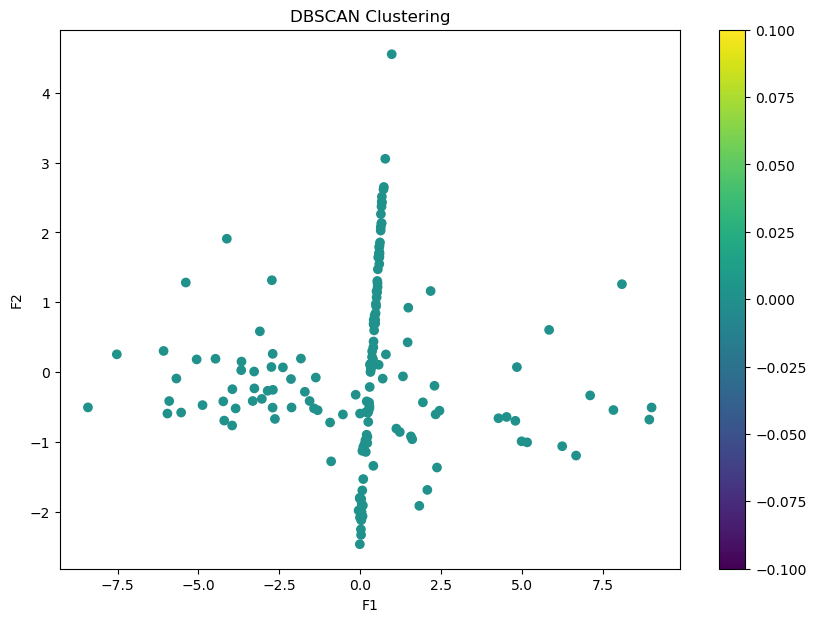

In [38]:
from sklearn.cluster import DBSCAN

# Préparation des données
X = df_test.values

# Création de l'objet DBSCAN
dbscan = DBSCAN(eps=5, min_samples=20)

# Fit et prédiction
clusters = dbscan.fit_predict(X)

# Ajout des labels de cluster au DataFrame
df['cluster_dbscan'] = clusters
unique = df['cluster_dbscan'].nunique()
print(unique)
# Création du graphique
plt.figure(figsize=(10, 7))
plt.scatter(df['F1'], df['F2'], c=df['cluster_dbscan'], cmap='viridis')

plt.title('DBSCAN Clustering')
plt.xlabel('F1')
plt.ylabel('F2')
plt.colorbar()
plt.show()

In [39]:
df['cluster_dbscan'] = df['cluster_dbscan'].replace({-1: 1, 0: 2})
df.sample(10)

,F1,F2,cluster_dd,cluster_kmeans,cluster_dbscan
8,-2.703972,0.262460,1,1,2
160,-4.202141,-0.693526,1,1,2
153,0.249895,-0.712267,2,2,2
69,1.828158,-1.913915,2,2,2
3,0.558384,1.645338,2,2,2
147,-0.012911,-1.798729,2,2,2
112,7.829070,-0.542304,2,2,2
150,-2.728718,1.316426,1,1,2
142,0.776217,3.055105,2,2,2
100,0.318661,0.002571,2,2,2


In [40]:
dbscan_labels = dbscan.labels_  # Liste des labels de cluster attribués par DBSCAN

In [41]:
# on va rapprocher nos clusters avec le dataframe initial
data['cluster_dbscan'] = df['cluster_dbscan']
data['cluster_kmeans'] = df['cluster_kmeans']  
data['cluster_dd'] = df['cluster_dd']
data.sample(10)

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant,cluster_dbscan,cluster_kmeans,cluster_dd
96,-0.090496,0.943861,0.000000,0.477984,-0.146932,0.104370,2,2,2
43,-0.040539,0.197744,-2.208000,-0.184538,0.532471,-0.193226,2,2,2
88,-0.876135,-0.565446,0.000000,-0.558172,-0.102391,-1.135245,2,2,2
155,-0.330545,-0.845603,-8.650538,-0.100914,0.004549,-0.323406,2,2,2
46,-0.713997,0.432718,0.000000,-0.323675,-0.194390,-0.212206,2,2,2
70,0.106742,-0.475555,2.099078,-0.367233,0.549953,0.761858,2,1,1
162,0.717261,-0.722952,4.620001,-0.953671,2.633990,1.030239,2,1,1
111,-0.853981,-0.240033,-1.027558,-1.342222,-0.139027,0.002557,2,2,2
138,0.217063,1.131975,4.128912,0.846764,0.361779,-0.024994,2,1,1
1,0.491588,-0.259106,0.189995,0.336682,0.894770,0.044080,2,2,2


# TEst éval cluster


In [42]:
data_num = data.select_dtypes(include=[np.number])

In [43]:
from sklearn.metrics import silhouette_score

# Calcul du score de silhouette pour chaque méthode de clustering
silhouette_dbscan = silhouette_score(data_num, data_num['cluster_dbscan'])
silhouette_kmeans = silhouette_score(data_num, data_num['cluster_kmeans'])
silhouette_dd = silhouette_score(data_num, data_num['cluster_dd'])

print(f'Silhouette Score DBSCAN: {silhouette_dbscan}')
print(f'Silhouette Score KMeans: {silhouette_kmeans}')
print(f'Silhouette Score DD: {silhouette_dd}')

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Les scores de silhouette que vous avez obtenus sont tous assez proches, ce qui suggère que les trois méthodes de clustering (DBSCAN, KMeans et DD) ont des performances similaires sur votre jeu de données.

Le score de silhouette varie de -1 à 1. Un score de silhouette proche de 1 indique que les échantillons sont bien regroupés dans leur propre cluster et mal regroupés dans les clusters voisins. Un score proche de 0 indique que les échantillons sont proches de la frontière de décision entre deux clusters. Un score proche de -1 indique que les échantillons sont mal regroupés.

Dans votre cas, tous les scores de silhouette sont autour de 0.65, ce qui suggère que les échantillons sont raisonnablement bien regroupés. Cependant, sans plus d'informations sur votre jeu de données et vos objectifs, il est difficile de dire quelle méthode de clustering est la meilleure. Vous devrez peut-être prendre en compte d'autres facteurs, tels que la signification des clusters, la robustesse des résultats, le temps d'exécution, etc.

C:\Users\antoi\AppData\Local\Temp\ipykernel_36292\4285572742.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap("Spectral")(i / 2)
c:\Users\antoi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\antoi\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


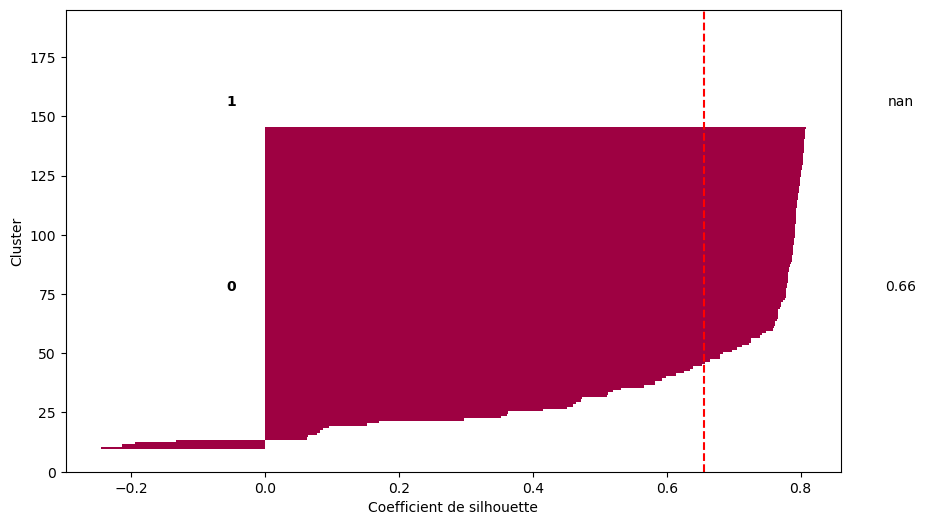

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Calculer les scores de silhouette pour chaque échantillon
silhouette_values = silhouette_samples(df_test, clusters)

# Calculer le score de silhouette moyen
average_silhouette_score = silhouette_score(df_test, clusters)

# Créer un graphique à barres horizontales des scores de silhouette
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(2):
    # Agréger les scores de silhouette pour les échantillons du cluster actuel
    cluster_silhouette_values = silhouette_values[clusters == i]
    cluster_silhouette_values.sort()
    
    # Calculer la taille du cluster actuel
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    
    # Tracer les scores de silhouette pour les échantillons du cluster actuel
    color = plt.cm.get_cmap("Spectral")(i / 2)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_values, height=1.0, edgecolor='none', color=color)
    
    # Calculer le score de silhouette moyen pour le cluster actuel
    cluster_average_silhouette_score = np.mean(cluster_silhouette_values)
    
    # Ajouter des étiquettes de texte avec le numéro du cluster et le score de silhouette moyen
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i), ha='center', va='center', fontweight='bold')
    plt.text(0.95, y_lower + 0.5 * cluster_size, f"{cluster_average_silhouette_score:.2f}", ha='center', va='center')
    
    # Mettre à jour la limite inférieure pour le prochain cluster
    y_lower = y_upper + 10

# Ajouter une ligne verticale au score de silhouette moyen
plt.axvline(x=average_silhouette_score, color='red', linestyle='--')

# Définir les limites et les étiquettes de l'axe y
plt.ylim(0, len(data_num) + (2 + 1) * 10)
plt.xlabel("Coefficient de silhouette")
plt.ylabel("Cluster")

# Afficher le graphique
plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score
kmeans_labels = kmeans.labels_
dendogram_labels = labels
# Assuming you have two sets of labels: true_labels and predicted_labels
ari = adjusted_rand_score(kmeans_labels, dendogram_labels)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 1.0
